## Data preparation

For tuning the ML models and augmentation parameters, we need to split the train set into a train set and validation set. If we were to use temporal info later, we need to separate storms instead of images.



In [1]:
from separate_val_data import separate_val_files 

In [2]:
train_dir = 'data/train'
val_dir = 'data/val' 
# val dictionary should not exist, otherwise, it would raise error to avoid runnig it multiple times.
val_fr = 0.2

separate_val_files(train_dir, val_dir, val_fr)

ValueError: data/val already exist.

## Directory structure

```
project
|____data
|    |____train
|    |     |___abc_001.jpg
|    |     |___abc_002.jpg
|    |
|    |____val
|    |     |___acc_001.jpg
|    |     |___acc_002.jpg
|    |
|    |____training_set_features.csv
|    |____training_set_labels.csv
|____separate_val_data.py
|____image_batch_gen.py
|____Hurricane.ipynb
```

## Make batch

In [1]:
import os
from os.path import join
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
class ImgBatchGen(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ground_truth_file, batch_size=32, img_size=None):
        self.bacth_size = batch_size
        files = os.listdir(img_dir)
        label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]
        random.shuffle(self.files)
        self.img_size=img_size
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images, labels = [], []

        for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
            img = cv2.imread(file, 0)
            if img is None:
                continue
            if self.img_size is not None:
                img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
            images.append(img)
            labels.append(label)

        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels).astype(np.float32)

        return x, y
    

In [3]:
img_size = 128
train_batchgen = ImgBatchGen('data/train', 'data/training_set_labels.csv', 32, img_size=img_size)
val_batchgen = ImgBatchGen('data/val', 'data/training_set_labels.csv', 32, img_size=img_size)

(32, 128, 128, 1) (32,)
35.0


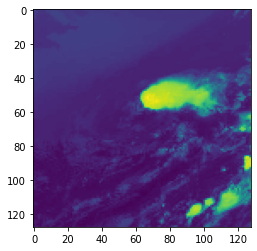

In [4]:
train_x, train_y = train_batchgen[0]
print(train_x.shape, train_y.shape)
plt.imshow(train_x[2])
print(train_y[2])

## Make Model

In [5]:
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

In [6]:
model = Sequential()
model.add(Conv2D(64, (7,7), padding='same', activation='relu', input_shape=(img_size, img_size, 1)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [7]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        2

In [8]:
## Train

In [ ]:
history = model.fit(val_batchgen, epochs = 100, verbose=1, validation_data=val_batchgen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 422 steps, validate for 422 steps
Epoch 1/100
422/422 [==============================] - 47s 112ms/step - loss: 229.7026 - mse: 229.7025 - mae: 10.4974 - mape: 23.5199 - val_loss: 402.2212 - val_mse: 402.2210 - val_mae: 14.0928 - val_mape: 30.1312
Epoch 2/100
422/422 [==============================] - 34s 81ms/step - loss: 93.3659 - mse: 93.3659 - mae: 6.9722 - mape: 15.8817 - val_loss: 65.6340 - val_mse: 65.6339 - val_mae: 6.1734 - val_mape: 15.0435
Epoch 3/100
422/422 [==============================] - 36s 85ms/step - loss: 49.8722 - mse: 49.8722 - mae: 5.1812 - mape: 11.8935 - val_loss: 57.2049 - val_mse: 57.2049 - val_mae: 5.2328 - val_mape: 10.9308
Epoch 4/100
422/422 [==============================] - 34s 82ms/step - loss: 31.2299 - mse: 31.2299 - mae: 4.1468 - mape: 9.6248 - val_loss: 44.3022 - val_mse: 44.3022 - val_mae: 5.1306 - val_mape: 11.9733
Epoch 5/100
422/422 [==============================] - 36s 85ms/step - l

In [ ]:
model.save('aug_1')


In [ ]:
ground_truth = []
pred = []
i = 0
for x_batch, y_batch in val_batchgen:
    pred.append(model.predict(x_batch).ravel())
    ground_truth.append(y_batch)
pred = np.hstack(pred)
ground_truth = np.hstack(ground_truth)

Text(0, 0.5, 'Prediction')

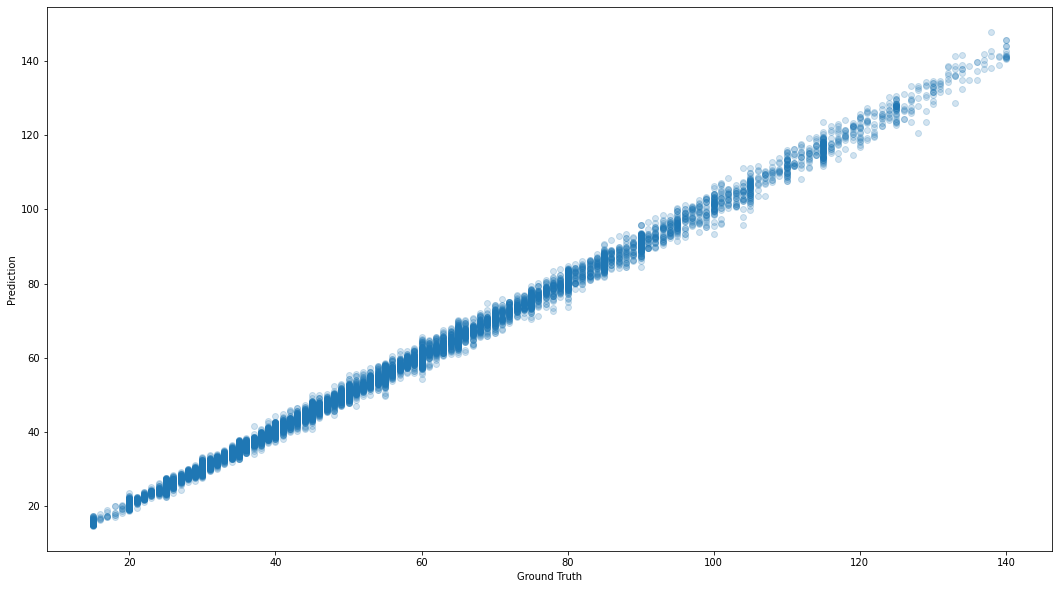

In [26]:
plt.figure(figsize=(18, 10))
plt.scatter(ground_truth, pred, alpha=0.2)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')